In [1]:
from torchvision import datasets, transforms
import torchvision
import torch
from net import AlexNetPlusLatent
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
%matplotlib inline

In [2]:
bits = 48
pretrained = 91.33

In [3]:
net = AlexNetPlusLatent(bits)
net.load_state_dict(torch.load('./model/91.33'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Use device: ' + str(device))
net.to(device)
net.eval()

Use device: cuda:0


AlexNetPlusLatent(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (remain): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p

In [4]:
def load_data(trans=1):
    transform_test = transforms.Compose(
        [
         transforms.Resize(227),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ]
    )
    
    transform_vis = transforms.Compose(
        [
         #transforms.Resize(32),
         transforms.ToTensor()
        ]
    )
    if trans:
        testset = datasets.CIFAR10(root='./data', train=False, download=True,
                                   transform=transform_test)
        _loader = torch.utils.data.DataLoader(testset)
    else:
        visset = datasets.CIFAR10(root='./data', train=False, download=True,
                                  transform=transform_vis)
        _loader = torch.utils.data.DataLoader(visset)
        
    return _loader

In [5]:
def int32_single_output(_data):
    _tensor = (single_output(_data)[0,:]>0.5).int()
    _str = ''
    for i in range(0, _tensor.shape[0]):
        _str += str(int(_tensor[i]))
    _int = int(_str, 2)
    return _int

In [6]:
def int32_aggregate_output(_loader):    
    #var intitialization
    _output = []    
    _transform = transforms.Compose([transforms.Scale(32), transforms.ToTensor()])
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(_loader):            
            _int = int32_single_output(inputs)
            b = (batch_idx, _int, int(targets) , inputs)
            if batch_idx%100==0:
                print('.', end='')
            _output.append(b)
        return _output

In [7]:
def find_picutre(given_pic_id, _list, _id_place=0):
    _output = [item for item in _list if item[_id_place] == given_pic_id]
    return _output[0]

In [8]:
def single_output(data):
    inputs = data.to(device)
    outputs, _ = net(inputs)
    return outputs.data

In [9]:
def hammingDistance(x, y):
    ans = 0
    for i in range(31,-1,-1):
        b1= x>>i&1
        b2 = y>>i&1
        ans+= not(b1==b2)
    return ans

In [10]:
def tpr(hash_list, _given_pic_class, ):
    #var initialization
    _tp = 0
    _fn = 0
    
    for (_, _, _list_pic_class) in hash_list:
        #identify TP, FP, FN
        if _given_pic_class == _list_pic_class:
            _tp += 1
        else:
            _fn += 1
    
    _tpn = _tp/(_tp + _fn)
    return _tp, _fn, _tpn

In [11]:
def overal_AP(hash_list, _given_pic_class):
    #var initialization
    _overal_AP = 0.0
    i = 0
    _tp = 0
        
    for (_, _, _list_pic_class, _) in hash_list:
        i += 1
        if _given_pic_class == _list_pic_class:
            _tp += 1
            _overal_AP += _tp/i
        
    return _overal_AP/_tp

In [12]:
def n_most_relative(_given_pic_id, hash_list, _num_of_pictures):
    #find given picture
    _given_pic = find_picutre(_given_pic_id, hash_list)
    
    #var initialization
    _output = []
    
    #extract given picture properties
    _given_pic_hash = _given_pic[1]
    _given_pic_class = _given_pic[2]
      
    for _list_pic in hash_list:        
        #extract list picture properties
        _list_pic_id = _list_pic[0]
        if (_given_pic_id != _list_pic_id):
            _list_pic_hash = _list_pic[1]
            _list_pic_class = _list_pic[2]
            _pic = _list_pic[3][0].numpy()
            _pic = np.transpose(_pic, (1, 2, 0))        

            #compute hamming distance
            _hamming_distance = hammingDistance(_given_pic_hash, _list_pic_hash)


            b = (hash_list[_list_pic_id][0], _hamming_distance, _list_pic_class, _pic)
            _output.append(b)
        
    #sort and crop output
    _pic = _given_pic[3][0].numpy()
    _pic = np.transpose(_pic, (1, 2, 0))
    
    _output = sorted(_output, key=lambda tup: tup[1])[0: _num_of_pictures]
    _output.insert(0,(_given_pic_id, 0, _given_pic_class, _pic))
    
    #compute TP, FN, TPN
    #_tp, _fn, _tpn = tpr(_output, _given_pic_class)
    
    #compute Overal AP
    _overal_AP = overal_AP(_output, _given_pic_class)
    print('Overal AP:', _overal_AP)
    
    return _overal_AP, _output

In [13]:
def visualize(images, columns=10):
    img = images[1][0][3]
    img = (img *(0.2023, 0.1994, 0.2010)+(0.4914, 0.4822, 0.4465))*255
    fig=plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(img.astype(np.uint8))
    plt.show()
    
    rows = math.ceil(len(images[1])/columns)
    fig=plt.figure(figsize=(columns,rows))
    i = 1
    for (_,_,_, image) in images[1]:        
        img = (image*(0.2023, 0.1994, 0.2010)+(0.4914, 0.4822, 0.4465))*255
        fig.add_subplot(rows, columns, i)
        plt.subplots_adjust(hspace = 0,wspace = 0)
        plt.axis('off')
        plt.imshow(img.astype(np.uint8))
        if i%columns==0:
            #print('.', end='')
            plt.show()
            fig=plt.figure(figsize=(columns,rows))
        i += 1
           

In [14]:
_loader = load_data()
_loader_v = load_data(0)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
hash_list = int32_aggregate_output(_loader)

c:\users\demer\miniconda3\envs\pytorch_deephash\lib\site-packages\torchvision\transforms\transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


....................................................................................................

In [16]:
def test(pic_id, n):
    _r = n_most_relative(pic_id , hash_list, n)
    visualize(_r, 13)

Overal AP: 0.9598854048686914


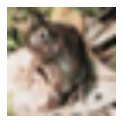

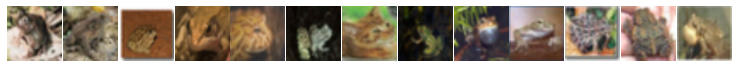

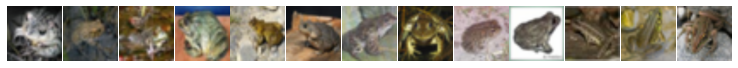

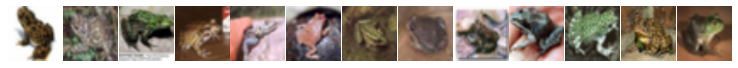

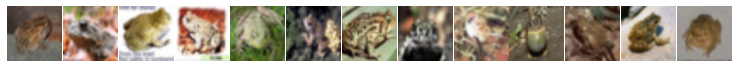

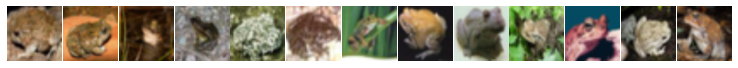

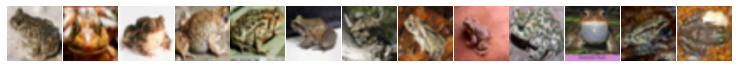

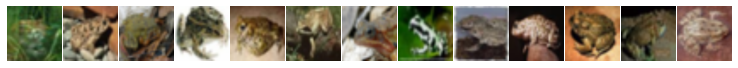

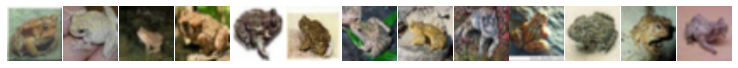

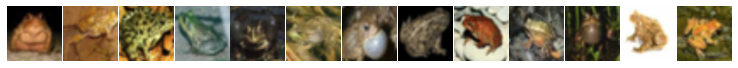

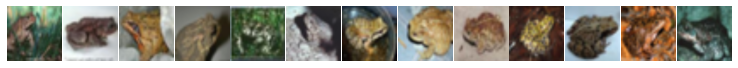

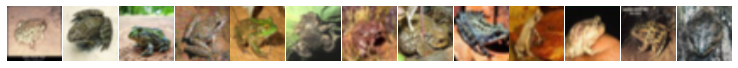

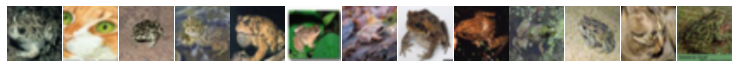

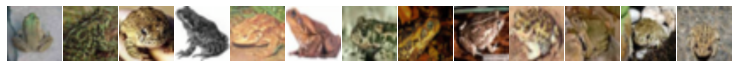

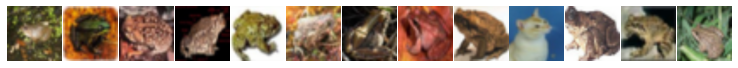

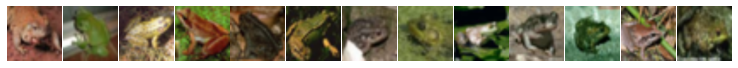

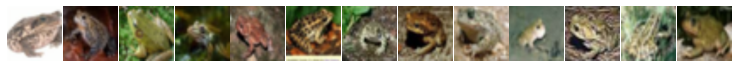

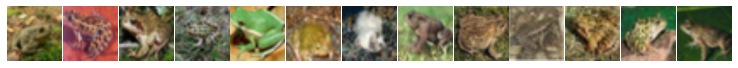

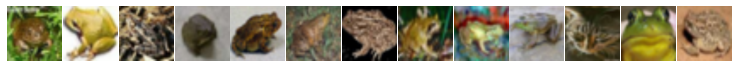

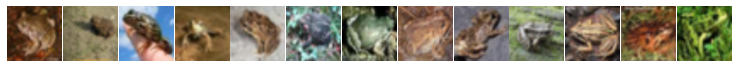

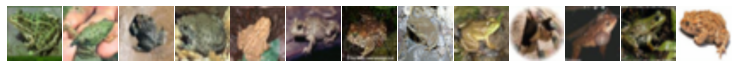

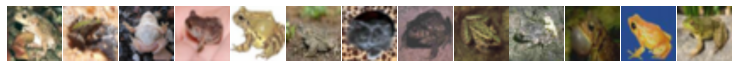

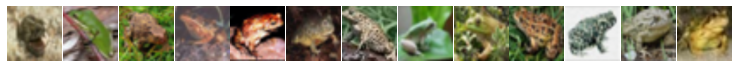

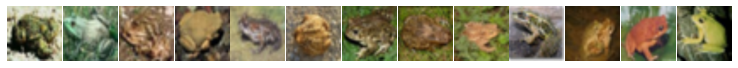

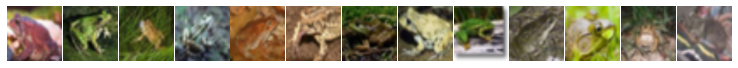

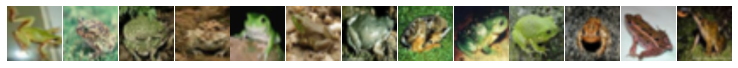

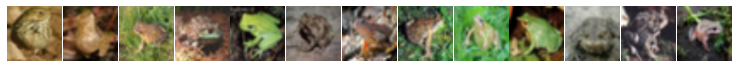

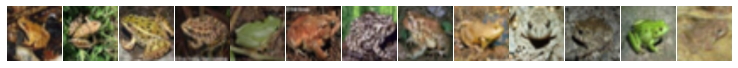

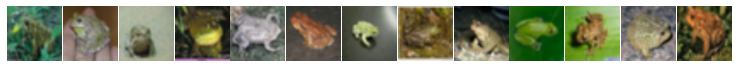

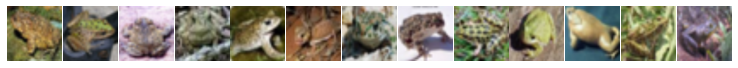

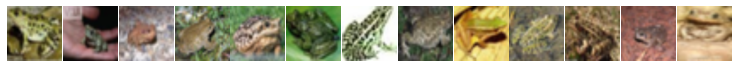

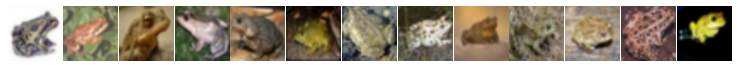

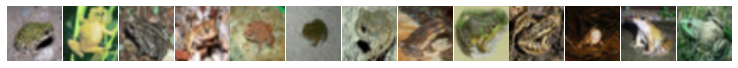

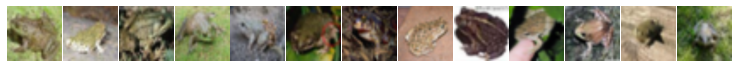

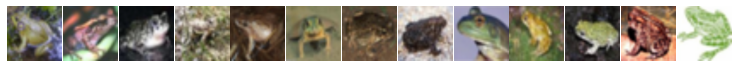

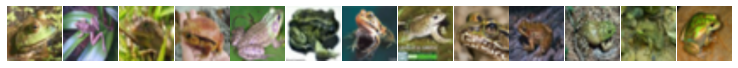

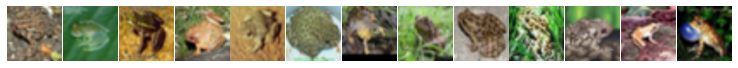

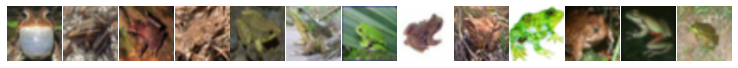

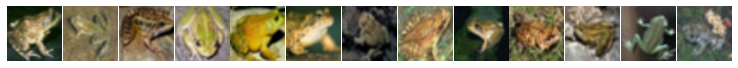

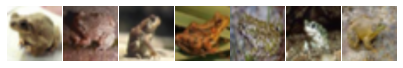

In [18]:
test(pic_id=8545, n=500)